#  SDCND: Deep Learning for Traffic Sign Recognition 

## Introduction 

**Note:** Where particular questions/answers are requested, they are filled in below, even if this involves repetition of the information mentioned elsewhere in the notebook. The document is meant to flow reasonably when read from top to bottom. Note that code is not necessarily below each question; where this is the case, there is appropriate guidance for the reader. Finally, please note that the bliolgraphy at the end of the notebook. 

---
## Step 0: Load The Data

In [ ]:
import numpy as np 
import pickle
import sklearn

# Just in case someone decides to run this... :-) 
# For the sake of whoever runs this, and my future self 
if int(sklearn.__version__.replace('.', '')) >= 180: 
    from sklearn.model_selection import train_test_split as tts
else:
    from sklearn.cross_validation import train_test_split as tts 
    

training_file ='train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


### A helper method

In [115]:
def which(bools_list): 
    return [i for i,val in enumerate(bools_list) if val]

---

## Step 1: Dataset Summary & Exploration  


In [3]:
n_train = len(y_train)
n_test = len(y_test)
image_shape = (X_train.shape[1], X_train.shape[2])
image_width = image_shape[1]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Image width =", image_width)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Image width = 32
Number of classes = 43


In [4]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.gridspec as pltgs

import cv2

%matplotlib inline

### Figure 1

Aside from establishing a working familiarity with the provided 
dataset, the objective of our visualization is to inform the structure of the neural 
network we will ultimately use.

This being the case, we begin with a mosaic of a randomly selected examples from each 
of our 43 classes. 

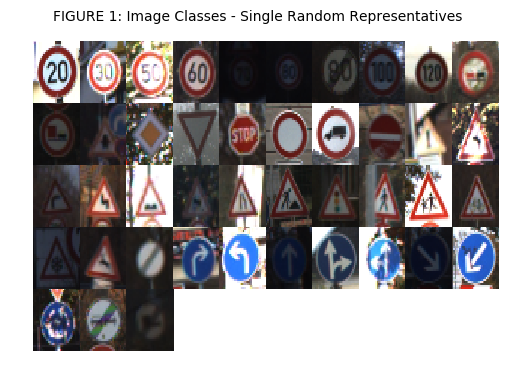

In [5]:
figure_1_images = list(map(lambda label: X_train[np.random.choice(which(y_train == label))], np.unique(y_train)))
figure_1_row_length = 10

figure_1 = plt.figure(1)
for i in range(0, len(figure_1_images)):
    figure_1_ax = figure_1.add_subplot(np.ceil(len(figure_1_images)/figure_1_row_length), figure_1_row_length, i+1)    
    figure_1_ax.imshow(figure_1_images[i], figure=figure_1, aspect='auto', interpolation='nearest')
    figure_1_ax.axis('off')
figure_1.subplots_adjust(wspace=0, hspace=0)
figure_1.suptitle('FIGURE 1: Image Classes - Single Random Representatives')


### Figure 2

Now, given that we have 43 classes (above) we visualize the distribution of these classes 
in our training dataset.

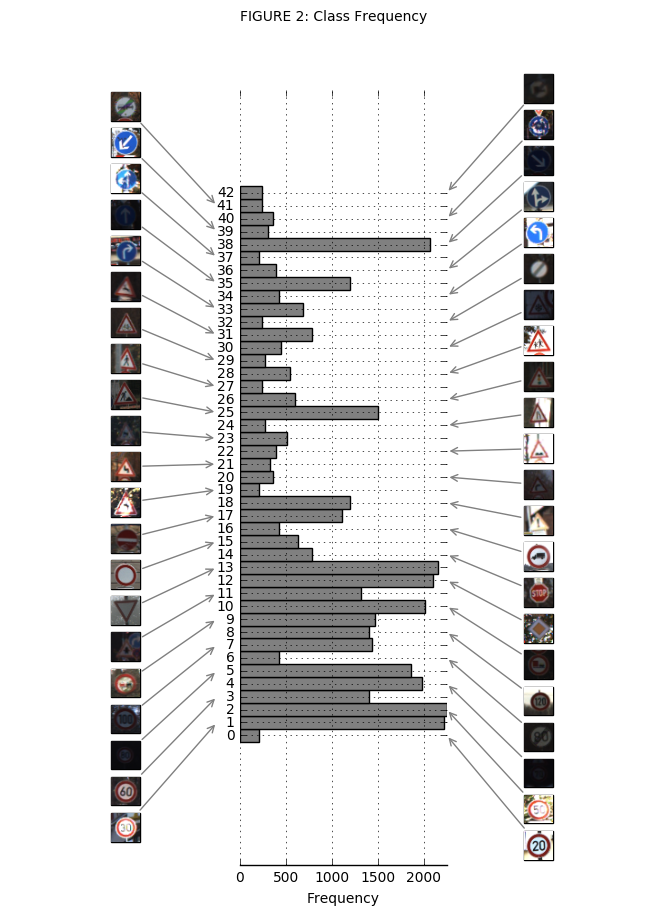

In [6]:
figure_2_labels,figure_2_freq = np.unique(y_train, return_counts=True)

figure_2_grid = pltgs.GridSpec(1,3)
figure_2 = plt.figure(2, figsize=(8,10))

figure_2_ax1 = figure_2.add_subplot(figure_2_grid[1])
figure_2_ax1.barh(figure_2_labels, figure_2_freq, 1, align='center', color='gray')
figure_2_ax1.grid(True)
figure_2_ax1.set_xlim([0,max(figure_2_freq)])

figure_2_ax1.spines['top'].set_visible(False)
figure_2_ax1.spines['right'].set_visible(False)
figure_2_ax1.spines['left'].set_visible(False)
plt.yticks(figure_2_labels, figure_2_labels, figure=figure_2)
plt.xlabel('Frequency')

# The coordinates of the thumbnails are computed in [0,60] and are then translated 
# down, so that they are centred w.r.t the left side of the figure. 
figure_2_thumbnail_coords_y = np.arange(0, 60, 60.0/len(figure_1_images))

figure_2_ax2 = figure_2.add_subplot(figure_2_grid[2],sharex=figure_2_ax1, sharey=figure_2_ax1)
for i in range(0, len(figure_1_images), 2):
    image_current  = OffsetImage(figure_1_images[i], zoom=0.9)
    figure_2_ann = AnnotationBbox(image_current, 
                                 xybox=[1000, figure_2_thumbnail_coords_y[i]-(60-len(figure_1_images))/2],
                                 xycoords='data',
                                 xy=[0,i],
                                 arrowprops=dict(arrowstyle="->", color='gray'),
                                 pad=0)
    figure_2_ax2.add_artist(figure_2_ann)
    plt.axis('off') 

figure_2_ax3 = figure_2.add_subplot(figure_2_grid[0],sharex=figure_2_ax1, sharey=figure_2_ax1)
for i in range(1, len(figure_1_images), 2):
    image_current  = OffsetImage(figure_1_images[i], zoom=0.9)
    figure_2_ann = AnnotationBbox(image_current, 
                                 xybox=[1000, figure_2_thumbnail_coords_y[i]-(60-len(figure_1_images))/2],
                                 xycoords='data',
                                 xy=[2000,i],
                                 arrowprops=dict(arrowstyle="->", color='gray'),
                                 pad=0)
    figure_2_ax3.add_artist(figure_2_ann)
    plt.axis('off') 

    
figure_2.subplots_adjust(wspace=0, hspace=0)                            
figure_2.suptitle('FIGURE 2: Class Frequency')


### Figure 3 

Below, examine the histograms of the random subset of images displayed in *Figure 1*. This demonstrates the extent of the contrast variation between the images in the training set, and the need for normalization. 

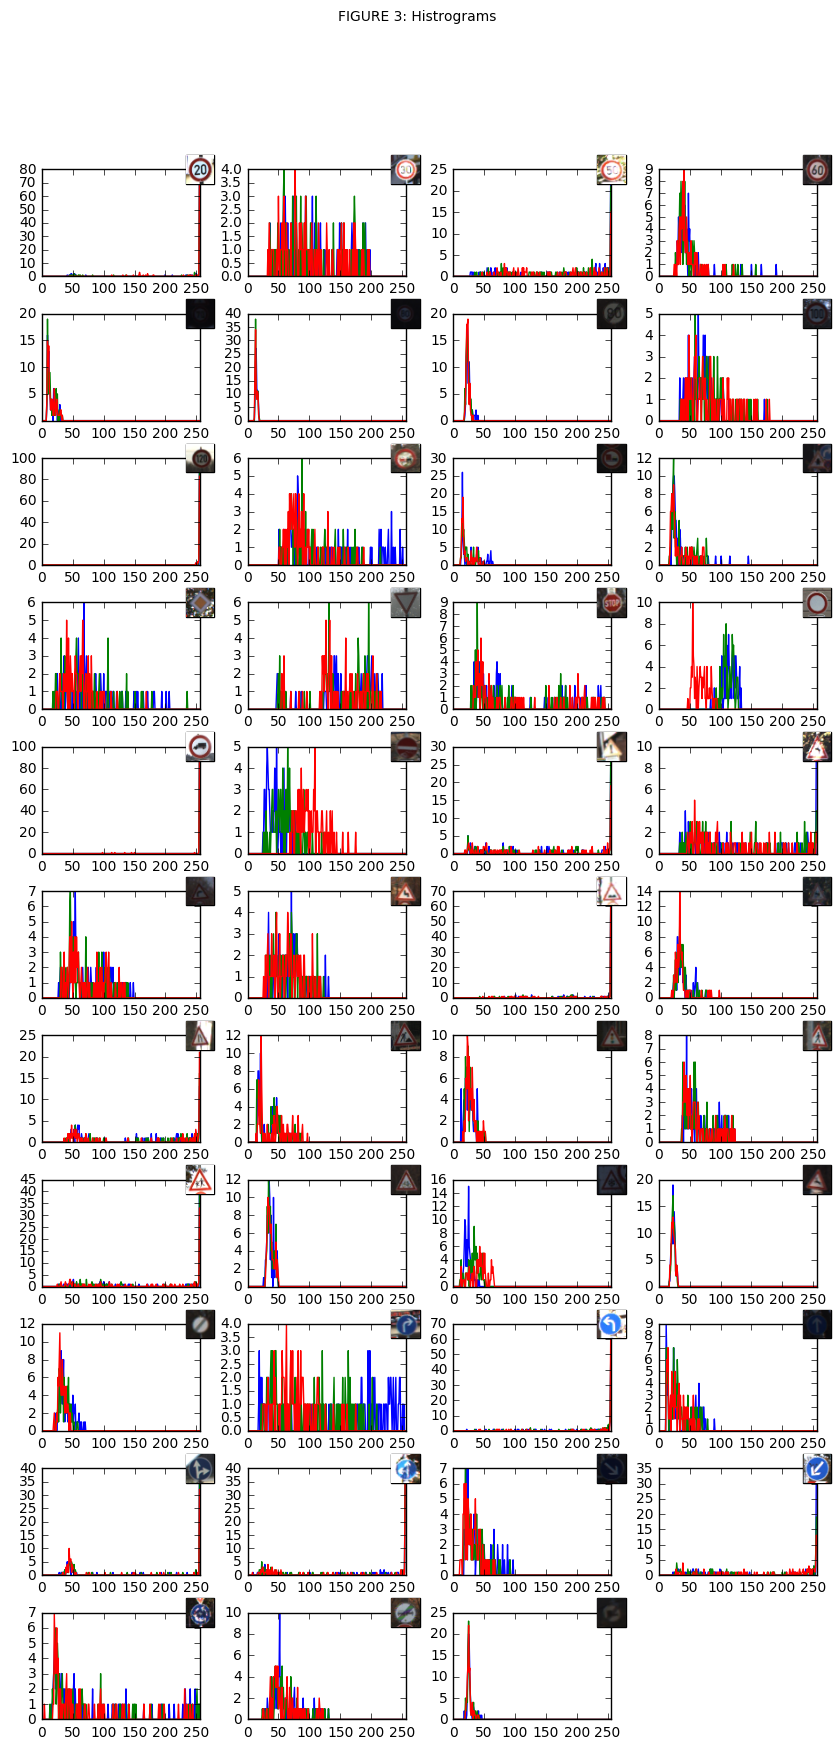

In [7]:
figure_3_row_length = 4

figure_3 = plt.figure(3, figsize=(10, 20))
for i in range(0, len(figure_1_images)):
    figure_3_ax = figure_3.add_subplot(np.ceil(len(figure_1_images)/figure_3_row_length), figure_3_row_length, i+1)
    for j,col in enumerate(('b', 'g', 'r')):
        figure_3_subhist = cv2.calcHist(figure_1_images[i], [j], None, [256], [0,256])
        figure_3_ax.plot(figure_3_subhist, color=col)
        figure_3_ax.set_xlim([0,256])
   
    # Give us a little thumbnail of the image to look at 
    image_current = OffsetImage(figure_1_images[i], zoom=0.9)
    figure_3_ann = AnnotationBbox(image_current,
                                xybox=[1, 1],
                                xy=[1, 1],
                                xycoords='axes fraction',
                                pad=0)
    figure_3_ax.add_artist(figure_3_ann)
        
figure_3.subplots_adjust(wspace=0.3, hspace=0.35)
figure_3.suptitle('FIGURE 3: Histrograms')

As is evident in the figure above, histogram normalization will likely greatly aid model performance. Furthermore, as the normalization operation can be performed independently for each image, it can be applied to all input data, and not only the training set. 

----

## Step 2: Design and Test a Model Architecture


### Relevant Litterature 
The model and pre-processing phases are inspired by the published material cited in the bibliography at the tail of this notebook. 

### Helper Methods

In [8]:
# Imports
import tensorflow as tf 
import cv2

def clahe_RGB(img, clipLimit, tileGridSize): 
    """ Apply Contrast-Limited Adaptive Histogram Equalization with OpenCV
    
    Contrast-Limited Adaptive Histogram Equalization is applied to each 
    of the three color channels of an RGB image. The result is returned 
    as an RGB image. 
    
    Args:
        img: Input image, should be in RGB colorspace. 
        clipLimit: Passed to cv2.createCLAHE
        tileGridSize: Passed to cv2.createCLAHE
    
    Returns: 
        The input image, with CLAHE applied, in RGB
    """
    
    r,g,b = cv2.split(img)
    
    img_clahe   = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    img_clahe_r = img_clahe.apply(r)
    img_clahe_g = img_clahe.apply(g)
    img_clahe_b = img_clahe.apply(b)
    
    img_ret = cv2.merge((img_clahe_r, img_clahe_g, img_clahe_b))

    return(img_ret)

def jitter_geom(img, deg_max=15, xy_max=2, scale_min=0.9, scale_max=1.1):
    """ Jitter an image, selecting parameters randomly within the specified range.
    
        Take in an RGB image, and, using openCV, randomly rotate, translate, and/or scale 
        the image according to the options specified by the user. OpenCV is used to apply 
        the transformations. If image pixels must be filled to maintain image dimensions, they 
        are given a value of 0. 
        
        Args: 
        
            img: RGB image 
            
            deg_max: Maximum number of degress by which we can rotate the image. Must be positive, 
            we can rotate in either counter clockwise, or clockwise. 
            
            xy_max: Minimum x/y values by which we can scale the image (must be positive, translation 
            may occur by +/- xy_max in either direction.)
            
            scale_min: Minimum allowed scaling (<= 1)
            scale_max: Maximum allowed scaling (>= 1)
        
        Returns: 
            An RGB color image with the translation applied. Image size remains the same, padding 
            with a pixel value of zero is added around the image. 
            
    """
    
    # Select parameters from the allowed ranges, for the transformation of this image.
    rn       = lambda xmax, xmin: np.random.uniform(xmin, xmax)
    rn_floor = lambda xmax, xmin: np.floor(np.random.uniform(xmin, xmax))
                
    img_h, img_w, _ = img.shape

    this_deg   = rn(-deg_max, deg_max)
    this_rotM  = cv2.getRotationMatrix2D((img_h/2, img_w/2), this_deg, 1)
    this_xy    = (rn_floor(-xy_max, xy_max), rn_floor(-xy_max, xy_max))
    this_scale = rn(scale_min, scale_max)
    
    # Transorm the image using OpenCV's geometric transformation machinery. 
    # Note that we're not using 'traditional' scaling here - we're sizing up the image and taking 
    # the size 'img' about the centre, or we're shrinking the image, and maitaining its dimensions 
    # with padding.     
    img_ret = cv2.warpAffine(img, M=np.float32([[1,0, this_xy[0]], [0,1,this_xy[1]]]), dsize=(img_w, img_h))
    img_ret = cv2.warpAffine(img_ret, M=this_rotM, dsize=(img_w, img_h))
    if this_scale <= 1: 
        new_h = int(np.floor(this_scale * img_h))
        new_w = int(np.floor(this_scale * img_w))
        img_ret = cv2.resize(img_ret, dsize=(new_w, new_h), interpolation=cv2.INTER_LINEAR)
        # Pad with 0s 
        img_ret = cv2.copyMakeBorder(img_ret, 
                                    top=(img_h - new_h), 
                                    bottom=(img_h - new_h), 
                                    left=(img_w - new_w), 
                                    right=(img_w - new_w),
                                    borderType=cv2.BORDER_CONSTANT, 
                                    value=[0,0,0,0])
    else:
        new_h = int(np.ceil(this_scale * img_h))
        new_w = int(np.ceil(this_scale * img_w))
        
        img_ret = cv2.resize(img_ret, dsize=(new_h, new_w), interpolation=cv2.INTER_LINEAR)
        diff_h = new_h - img_h
        diff_w = new_w - img_w
        img_ret = img_ret[diff_h:(diff_h+img_h), diff_w:(diff_w + img_w),:]

    img_ret = cv2.resize(img_ret, dsize=(img_h, img_w), interpolation=cv2.INTER_LINEAR)
    return img_ret 

### Dataset preparation and augmentation

Prior to the definition of a neural network architecture, we create separate datasets with various forms of pre-processing.

#### CLAHE
All methods cited above involve some degree of preprocessing. In particular, input images are generaly contrast-normalized in all approaches cited above **[1-6]**, and it is recommended in **[7]** as a means of removing unwanted variation in contrast between input images.  
While the authors in **[2]** opt for global contrast normalization, Ciresan et. al. opt for a local normalization method in **[1]**. 
In **[1]** the authors opt for contrast-limited adaptive histogram equalization (CLAHE) whereby normalization is applied in tiles across the image, and image is contrast is limited to avoid the amplification of noise. [The OpenCV documentation provides a  description of the procedure](http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html). The neural network implemented by **[1]** also achieved heighest performance on images normalized with the CLAHE method. This being the case, CLAHE  is also applied here, and its effect may be visualized below, on the set of sample images in *Figure 1*.  

Histogram normalization can be applied to any image feed - as such, it is appopriate to pre-process the test set as well, using the same method. 

##### Figure 4
CLAHE applied to the set of sample images in *Figure 1*. Note the increased visibility of the road signs, particularly in darker images. The CLAHE procedure is applied with OpenCV, with a clipping limit of 1.0 and 4x4 tiles. 

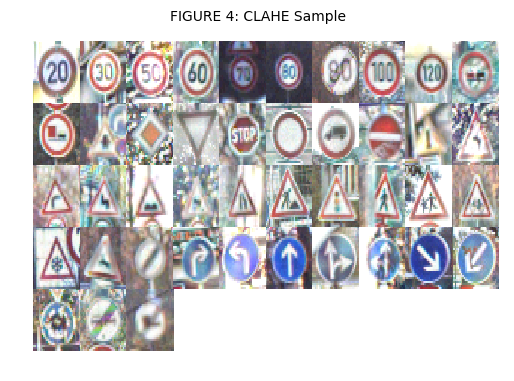

In [9]:
figure_4 = plt.figure(4)
for i in range(0, len(figure_1_images)):
    figure_4_ax = figure_4.add_subplot(np.ceil(len(figure_1_images)/figure_1_row_length), figure_1_row_length, i+1)
    img_clahe = clahe_RGB(figure_1_images[i], clipLimit=1.0, tileGridSize=(4,4))
    figure_4_ax.imshow(img_clahe, aspect='auto', interpolation='nearest')
    figure_4_ax.axis('off')
    
figure_4.subplots_adjust(wspace=0, hspace=0)
figure_4.suptitle('FIGURE 4: CLAHE Sample')


#### Jitter Augmentation
In **[7]**, dataset augmentation is described as a useful means of generalizing a classifier. In **[2]**, Sermanet and LeCujn augment the traffic sign (training) datset with a "jittered dataset", formed by rotating, scaling, and translating the original images. The authors note that adding slightly 'deformed' versions of the input data will yield a more robust model. 

Here, a similar approach is adopted for the augmentation of the **training** (only, obviously) dataset. While the authors in **[2]** opted for a 5-fold augmentation of the original training set, for the sake of expediency, and to permit experimentation, we opt for only the addition of one jittered augmentation. 

An example of jitter, is visuazlized using the training set pre-processed with CLAHE, in *Figure 5*, below. The same translation, rotation, and scale range as **[2]** are used.

##### Figure 5 
Example of jitter, applied to the images depicted in *Figure 4*. The images are randomly rotated, translated, and scaled by a small amount. 

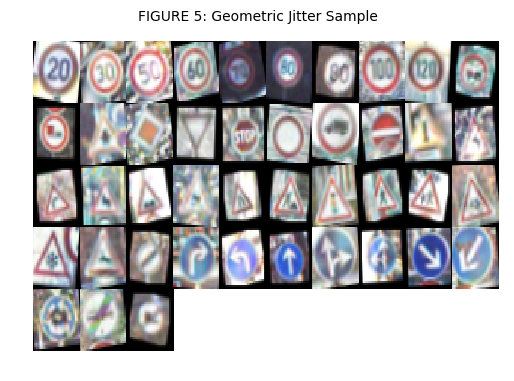

In [10]:
figure_5 = plt.figure(5)
for i in range(0, len(figure_1_images)):
    figure_5_ax = figure_5.add_subplot(np.ceil(len(figure_1_images)/figure_1_row_length), figure_1_row_length, i+1)
    img_jitter = jitter_geom(clahe_RGB(figure_1_images[i], clipLimit=1.0, tileGridSize=(4,4)))
    figure_5_ax.imshow(img_jitter, aspect='auto', interpolation='nearest')
    figure_5_ax.axis('off')
    
figure_5.subplots_adjust(wspace=0, hspace=0)
figure_5.suptitle('FIGURE 5: Geometric Jitter Sample')

### Data Preparation

In [11]:
# Local methods for applying our clahe and geometric jitter 
clahe_local = lambda image: clahe_RGB(image, clipLimit=1.0, tileGridSize=(4,4))
jitter_geom_local = lambda image: jitter_geom(image, deg_max=15, xy_max=2, scale_min=0.9, scale_max=1.1)

X_test_clahe = np.asarray([clahe_local(image) for image in X_test])
y_test_clahe = np.copy(y_test)

X_train_jitter = np.concatenate((X_train, np.asarray([jitter_geom_local(image) for image in X_train])))
X_train_jitter = np.concatenate((X_train_jitter, np.asarray([jitter_geom_local(image) for image in X_train])))
X_trian_jitter = np.concatenate((X_train_jitter, np.asarray([jitter_geom_local(image) for image in X_train])))

X_train_jitter_clahe = np.asarray([clahe_local(image) for image in X_train_jitter])

y_train_jitter_clahe = np.concatenate((y_train, y_train, y_train))

print("Original - shape:", X_train.shape)
print("OriginalT- shape:", X_test.shape)

print("Augmented- shape:", X_train_jitter_clahe.shape)
print("Augmented- shape:", y_train_jitter_clahe.shape)

# Delete what we do not need. 
del X_train_jitter 

Original - shape: (39209, 32, 32, 3)
OriginalT- shape: (12630, 32, 32, 3)
Augmented- shape: (117627, 32, 32, 3)
Augmented- shape: (117627,)


In [12]:
# Split between training and validation
X_train_final, X_validation_final, y_train_final, y_validation_final = tts(
    X_train_jitter_clahe, y_train_jitter_clahe, test_size=0.2, random_state=1729)

print("Training - shape:", X_train_final.shape)
print("Validation - shape:", X_validation_final.shape)


Training - shape: (94101, 32, 32, 3)
Validation - shape: (23526, 32, 32, 3)


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** Both image datasets are pre-processed with contrast-limited adaptive histogram normalization (CLAHE). Histogram normalization is a standard pre-processing technique for computer vission application **[1-7]**. Furthermore, CLAHE was applied in **[1]** with results superior to other normalization techniques. The authors in **[2]** opt for global normalization, but local normalization techniques, CLAHE included, are more suited to highlighting edges in darker regions **[7]**. The goal of histogram normlaizatoin in computer vision applications is the exclusion of spurious variation due to image contrast, which, as is the case here, not consequential to the final classification task **[7]**. 

*Figures 1,3,4* demonstrate the clear need for histogram normalization here. Note the increased definition and identifiability of edges in *Figure 4,* after normalization is applied. CLAHE is applied here using OpenCV: the normalization is performed separately for each color channel (R, G, B) of the input images, and the normalized channels are recombined. 

This is an appropriate pre-processing step for both the training and test sets, and is the only pre-processing step perfomred here. CLAHE is applied independently for each image, this means that any querry image presented to the model could be pre-processed with CLAHE prior to testing. To nod to the application at hand, we may consider that a video feed being streamed into a sign detection algorithm, could have every frame pre-processed with CLAHE prior to the application of road-sign detection and identification procedures. In **[7]**, Goodfellow et. al. note that computer vision applications generally require little pre-processing. Indeed, the images in this case have already been cropped and reasonably formatted, prior to the distribution of the training and testing data, as can been seen from the description of the raw data (the source data is the same) in **[1,2]** etc.

The code block above this question, and the helper methods at the opening of the 'Step 2' section, contain the implementation. Note that centring the training data is discussed in the response to *Question 2,* below. 

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** To augment the training data, a jittered dataset, in the style of **[2]** is added to the existing examples. Sermanet et. al. note that the architecture of convolutional neural networks are intrinsically invariant to small geometric transformations **[2]**. Goodfellow et. al. in **[7]** also describe the benefits of data-augmentation schemes, where transformations are applied to each training instance in such a way that they will not change the class of the instance. 

The source which contains the jittering procedure and the generation of the dataset is to be found in the code cells above *Question 1* and the helper methods defined at the opening of the *Step 2* section.

Other approaches are certainly feasible and worthy of further experimentation. For example, in **[8]**, Krizhevsky et. al. also perform color-based augmentation. In their approach, an augmented set is formed by adding a random value to each pixel proportional to the eigenvectors obtained via principle component analysis of each color channel across the entire training set **[8]**. It is perhaps worth noting that the authors of **[8]** perform only simple global centring of pixel values across the entire dataset. The method is not applied here, but the authors of **[8]** note that it decreased the top-1 error rate on the ImageNet dataset by approximately 1%. A further experiment, beyond the scope of this project, could reveal the utility of the method in **[8]** in concert, or as an alternative to, local normalization. Whereas normalization can usually be applied to both training and testing data, there may exist situations where this is not possible. For such cases, where, for example, a test image may not be pre-processed in any way due to operational constraints, the method in **[8]** may make up for a lack of normalization. 

Aside from the augmentation described above, each training set is shuffled to reduce the bias introduced by the order of the images. Furthermore, an effort is made to reduce intrinsic bias in the dataset by subtracting, from each channel of each pixel, its mean value across the entire training set. This centres each image about a common origin. This type of centring is common to many machine learning applications across disciplines **[7,8]**. As before, see the code blocks above *Question 1* for the relevant sources. 

### Model Architecture

The architecture implemented below is based on that of Ciresan et. al., 2011, Sermanet et. al. 2011, and Krizhevsky et. al., 2012 **[1,2,8]**. Further details are presented in the response to *Question 3,* below. 

In [13]:
from tensorflow.contrib.layers import flatten 

def tf_convolution(previous_layer, h, w, n, strides=[1,1,1,1], padding='VALID', activationF=tf.nn.relu):
    """ Wrapper for constructing tensor flow 2d convolutions. 
    
    Note that the layers is initialized with weights chosen according to a truncated 
    normal distribution: Norm(0, 0.1). 
    
    Args: 
        previous_layer: The previous layer being input to this convolution
        
        h: Convolution first dimension, height
        
        w: Convolution second dimension, width
        
        n: Number of output feature maps 
        
        strides: Strides input to conv2d (default is [1,1,1,1])
        
        padding: Padding input to conv2d (default is 'VALID')
        
        activationF: Activation function (must be a valid tensorflow activation function, 
        in the spirit of the default, which is tf.nn.relu)
        
    Returns: 
        Convolution with the activation function applied. 
    """
    conv_W = tf.Variable(tf.truncated_normal(shape=(int(h), int(w), int(previous_layer.get_shape()[3]), int(n)), 
                                              mean=0, stddev=0.1))
    conv_b = tf.Variable(tf.zeros(n))
    conv = tf.nn.conv2d(previous_layer, conv_W, strides=strides, padding=padding) + conv_b 
    
    conv = activationF(conv)
    
    return conv

def inception_module(previous_layer): 
    """ Implements the inception module from Szegedy et. al. 2015
    
    The module is composed of a numbver of convolutions (3x3, 5x5), and a 3x3 max pooling layer, 
    combined with 1x1 convolutions for dimensionality reduction.
    
    A simple outline of the architecture. 
    
   { input 
       { 1x1 convolution 
           { 3x3 convolution 
               { output0 }
           }
           { 5x5 convolution 
               { output1 }
           } 
           { output2 }
       } 
       { 3x3 max pooling 
           { 1x1 convolution 
               { output3 }
           } 
       }
    }
   
    Finally {output0, output1, output2, output3} are concatenated together 
    and returned as though they were a single layer. 
    
    Args: 
        previous_layer: Input layer to this inception module 
        
    Returns: 
        Concatenated results, as output layer. 
    """
    
    # 1x1 convolutions directly from the previous layer 
    conv1x1 = tf_convolution(previous_layer=previous_layer, h=1, w=1, n=12, padding='SAME', activationF=tf.nn.relu)
   
    # 3x3 and 5x5 convolutions following 1x1 convolutions
    conv3x3 = tf_convolution(previous_layer=conv1x1, h=3, w=3, n=12, padding='SAME', activationF=tf.nn.relu)
    
    conv5x5 = tf_convolution(previous_layer=conv1x1, h=5, w=5, n=12, padding='SAME', activationF=tf.nn.relu)
    
    # Max pooling 3x3 directly following the previous layer, followed by 1x1 convolution 
    maxp3x3 = tf.nn.max_pool(previous_layer, ksize=[1,3,3,1], padding='SAME', strides=[1,1,1,1])
    maxp3x3_conv1x1 = tf_convolution(previous_layer=maxp3x3, h=1, w=1, n=12, padding='SAME', activationF=tf.nn.relu)
    
    return tf.concat(3, [conv1x1, conv3x3, conv5x5, maxp3x3_conv1x1]) 

def signception(x): 
    
    """ Signception network architecture
    
    The architecture is as follows: 
    
    1. Convolution (5x5)
    2. Max pooling (2x2)
    3. Incedption (max depth 2, see above)
    4. Max Pooling 
    5. Inception (max depth 2, see above)
    6. Max pooling 
    7. Inception (max depth 2, see above)
    8. Max pooling 
    9. Fully connected 
    10. Fully connected 
    11. Classification 
    
    Args:
        x: Input data 
    
    Returns: 
        Classified output, for 43 image classes
    """
    mu = 0 
    sigma = 0.1      
    
    conv1 = tf_convolution(x, h=5, w=5, n=10, padding='VALID', activationF=tf.nn.relu)
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    mod1 = inception_module(conv1)    
    mod1 = tf.nn.max_pool(mod1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    mod2 = inception_module(mod1)
    mod2 = tf.nn.max_pool(mod2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    mod3 = inception_module(mod2)
    mod3 = tf.nn.max_pool(mod3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    
    full5 = flatten(mod2)
    
    full6_W = tf.Variable(tf.truncated_normal(shape=(432,200), mean=mu, stddev=sigma))
    full6_b = tf.Variable(tf.zeros(200))
    full6 = tf.matmul(full5, full6_W) + full6_b
    full6 = tf.nn.relu(full6)
    
    full7_W = tf.Variable(tf.truncated_normal(shape=(200,120), mean=mu, stddev=sigma))
    full7_b = tf.Variable(tf.zeros(120)) 
    full7 = tf.matmul(full6, full7_W) + full7_b
    full7 = tf.nn.relu(full7)
    
    full8_W = tf.Variable(tf.truncated_normal(shape=(120,43), mean=mu, stddev=sigma))
    full8_b = tf.Variable(tf.zeros(43)) 
    full8_ret = tf.matmul(full7, full8_W) + full8_b
    
    return full8_ret

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** The final architecture is implemented in the method `signception`, and, as the name would suggest, it is based on Google's 'Inception Architecture' **[9]**, and on the netoworks implemented  in **[1,2]** which were designed for the sign classification task. The network used here is illustrasted in the following diagram - this diagram was produced with [Ipe](http://ipe.otfried.org/). 

The inception module shown here, and described by **[9]** has an interesting similarity with the network implemented in **[2]**. The overall architecture mimics that of **[1]**, however each hidden convolutional layer, is replaced by an inception module. For heuristic purposes we will consider the inception module, as in **[9]**, as having a maximum of two layers. This being the case, *the network here can be said to contain 11 layers*. For particular filter sizes, see the diagram below. 

A particular advantage over the networks of **[1]** and **[2]** is training time. Indeed, trainig for 1000 epochs only takes a handful of hours, whereas the networks in **[1]** and **[2]** were trained over the course of many days. Of course, continuing to train the network shown here would likely increase its accuracy, but even when accuracy is taken into account, the efficiency gains are non-negligible, considering the depth and size of this network. The source of this efficiency is the use of an inception module, and the dimensionality reduction (reduction in the number of parameters) that this particular sub-architecture includes **[9]**.  


#### The SIGNCEPTION Network
![The SIGNCEPTION Network](./signception_diagram.png)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


In [ ]:
def evaluate(x, y, X_data, y_data, tf_session, batch_size, acc_op):
    """ Evaluate the signception model 
    
    Args: 
        x: Signception tensorflow x placeholder 
        y: Signception tensorflow y placeholder 
        X_data: Input data, feautres
        y_data: Input data, class labels to which the result of applying the model on 
        X_data is to be compared 
        tf_session: Tensorflow session 
        batch_size: Batch size for model application 
        acc_op: Tensorflow accuracy operation 
        
    Returns: 
        Computed when the model defined in tf_session is applied to X_data, and the 
        results compared to y_data.     
    """
    num_examples = len(X_data)
    total_accuracy = 0
   
    for offset in range(0, num_examples, batch_size):
       
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = tf_session.run(acc_op, feed_dict={x: batch_x, y: batch_y})
        
        total_accuracy += (accuracy * len(batch_x))
    
    return total_accuracy / num_examples


def signception_model_train(X_training_data, y_training_data,
                            X_validation_data, y_validation_data, 
                            epochs, batch_size, rate):
    """ Train the signception model, given a number of hyperparameters. 
    
    Args: 
        X_training_data: Training input data (features)
        y_training_data: Training class lables
        X_validation_data: Validation input data (features)
        y_validation_data: Validation class lables
        epochs: Maximum number of training epochs 
        batch_size: Training batch size 
        rate: Learning rate 
    Returns: 
        (x, y, saver, accuracy_operation, accuracy_collected) where 
        x is the placeholder for our features in the tensorflow model, y is the one-hot encoded 
        placeholder for the class labels, accuracy_operation is the tensorflow accuracy operation 
        to apply/being applied in the 'evaluate' method, and accuracy_collected is the collected 
        validation accuracy over all training epochs. 
    """  
    
    
    G = tf.Graph()
    
    with G.as_default(): 
        x = tf.placeholder(tf.float32, (None, 32, 32, 3)) 
        y = tf.placeholder(tf.int32, (None))
        one_hot_y = tf.one_hot(y, 43)

        logits = signception(x)
        softmax = tf.nn.softmax(logits)
    
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
        loss_operation = tf.reduce_mean(cross_entropy) 
    
        optimizer = tf.train.AdamOptimizer(learning_rate = rate)
        training_operation = optimizer.minimize(loss_operation)

        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
        acc_collector = [] 
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_training_data)
    
            print("Training...")
            print()
            for i in range(epochs):  
                # Shuffling
                from sklearn.utils import shuffle 
    
                X_training_data, y_training_data = shuffle(X_training_data, y_training_data)
                
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size
                
                    batch_x, batch_y = X_training_data[offset:end], y_training_data[offset:end]
                    
                    sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
                    
            
                validation_accuracy = evaluate(x=x, y=y,
                                               X_data=X_validation_data, 
                                               y_data=y_validation_data,
                                               tf_session=sess, 
                                               batch_size=batch_size, 
                                               acc_op=accuracy_operation)
                
                acc_collector = acc_collector + [validation_accuracy]
                print("EPOCH {} ...".format(i+1))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy))
                print()
                if validation_accuracy > 0.990: 
                    break 
        
            saver = tf.train.Saver()
            saver.save(sess, 'signception.chkpt')
            return {'x':x, 'y':y, 'accuracy_operation':accuracy_operation, 'softmax_operation':softmax, 
                    'saver':saver, 'collected_accuracy':acc_collector, 'graph': G}

model_data = signception_model_train(X_train_final, 
                                     y_train_final, 
                                     X_validation_final, 
                                     y_validation_final, 
                                     epochs=1000, 
                                     batch_size=256, 
                                     rate=0.0005)


**Answer:**  The model is trained in batches of size 256, a maximum of 1000 epochs, and a learning rate of 0.0005. Training was halted when the validation accuracy was greater than 0.990, as this was deemed sufficient for the sake of this little experiment. Hyperparameters were tuned by experimental trial and error, and by heuristic assessment. In a more realistic setting, it would be reasonable, as is common practice, to randomly train and evaluate diverse architecture patterns and hyperparameter choices, selecting the top performing candidates (in the syle of **[2]**). This would, however, bring with it a significant computational burden, and is, perhaps, beyond the spoke of this small exploratory project. It will be the subject of a future experiment.

A further improvement which is not implemented here, would be the addition of a decay parameter, decreasing the learning rate as the number of training epochs increases. This is common practice with gradient descent, giving the optimizaiton algorithm a 'higher resolution' as it approaches convergence. As an alternative here, and becase there is little documentation of the usefullness of this practice with the ADAM optimizer **[10]** mentioned below, we substitue a small learning rate, and more training epochs. 

The ADAM optmizer (Kingma et. al., 2014) **[10]** was selected as a recent, and more efficient alternative to stochastic gradient descent. Further investigation of its utility would be a worthwhile avenue for further experimentaiton. 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

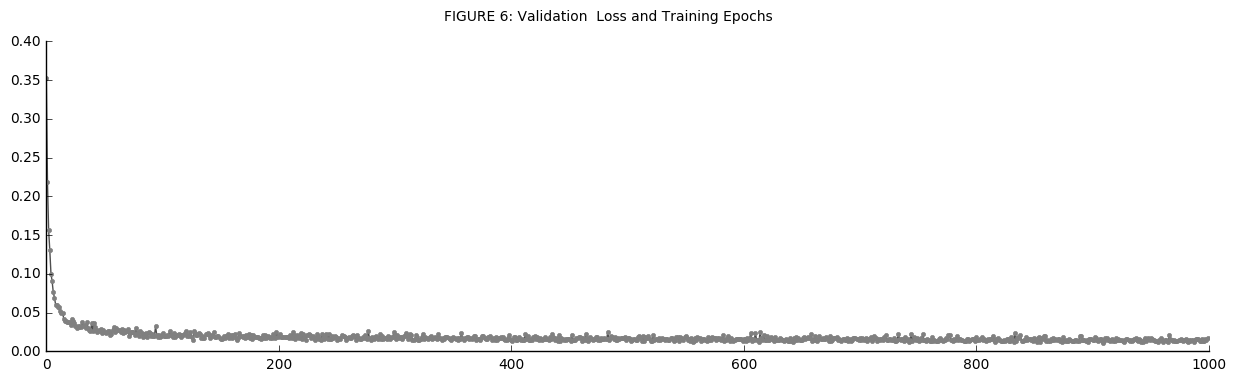

In [68]:
# A pleasing graph - the type of oscilating plot one expects...
from statsmodels.nonparametric.smoothers_lowess import lowess
acc_plt = [1-acc for acc in model_data['collected_accuracy']]
figure_6 = plt.figure(6, figsize=(15, 4))
figure_6_ax = plt.subplot(111)
figure_6_ax.plot(acc_plt, '-', color='#4F4F4F')
figure_6_ax.plot(acc_plt, '.', color='gray')
figure_6_ax.spines['right'].set_visible(False)
figure_6_ax.spines['top'].set_visible(False)
figure_6_ax.xaxis.set_ticks_position('bottom')
figure_6_ax.yaxis.set_ticks_position('left')
figure_6.suptitle('FIGURE 6: Validation  Loss and Training Epochs') 

**Answer:**
Broadly speaking, the steps involved with this project were: 

1. A review of current litterature on image classification with the GTSB dataset 
2. A review of more recent (the GTSB dates to the early 2010s) image classification architectures 
3. Select and implement a robust pre-processing regime
4. Determining the extent to which the optimizations one might want to implement are available in the TensorFlow API
5. Experimentation with a number of architectures and hypterparameter choices

The solution presented here is based largely on published material, and on a number of personal experiments. As with any reserach or engineering problem any experimentation must be proceeded by a reasonable litterature review. The problem of visual classification of images has been well-studied, and a number of well known architectures have been developed to cope with such tasks. This cohort of availble solutions includes those constructed for the German Traffic Sign Benchmark (GTSB) dataset **[1,2,4, and others, not cited]** from which the provided trianing and testing sets are derived.For example, the pre-processing steps implemented here are directly based on those applied in **[1,2]**, where the authors were directly concerned with the same problem. 
 
This is not to say that there is not room for experimentation in model selection, even for a well studied problem. In this case the model presented, as discussed previously, is based on a number of competing sources. An effort is made to experiment with the injection of more up to date architectures (for example, the inception architecture **[9]**, into schemas which successfully solved the target problem in the past **[1,2]**.  In particular, more up to date architectures bring efficiency gains, accelerating training time, and enabling more experimentation, which is key to this project as an educational exercise. 

In [69]:
with model_data['graph'].as_default():
    with tf.Session() as sess: 
        saver = model_data['saver']
        saver.restore(sess, './signception.chkpt')
        
        test_accuracy = evaluate(model_data['x'], model_data['y'], X_test, y_test, batch_size=256, acc_op = model_data['accuracy_operation'], tf_session=sess)
        print("Test Accuracy (without CLAHE)= {:.3f}".format(test_accuracy))
    
        test_accuracy = evaluate(model_data['x'], model_data['y'], X_test_clahe, y_test_clahe, batch_size=256, acc_op = model_data['accuracy_operation'], tf_session=sess)
        print("Test Accuracy (with CLAHE)= {:.3f}".format(test_accuracy))
    
       
       

Test Accuracy (without CLAHE)= 0.880
Test Accuracy (with CLAHE)= 0.966


Were the algorithm permitted a longer training time, the accuracy would increase further. Note that CLAHE is applied independtly to each image here and, as mentioned previously, is a suitable transformation for both the testing and training set (the input to an 'on-line' version of this algorithm could easily be normalized in real time - in the case of video, the application of CLAHE to frame *i* is carried out independently from the application of CLAHE to frame *j*, for $i \neq j$). 

---

## Step 3: Test a Model on New Images

A second dataset of Spanish road-sign images was collected by Maldonado et. al., in 2007 **[6]**. Five images selected from this dataset, cropped and rescaled, are shown below. The dataset in question is obtainable here: http://agamenon.tsc.uah.es/Investigacion/gram/traffic_signs.html . 


### Implementation

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** See the images below. These traffic signs are similar to those found in GTSB, as they are both from European nations, save from some minor differences. For the sake of experimentation, the images will be presented to classifier without normalization. 

**Most importantly the GTSB dataset does not have a 'Max 40 km/h' sign, which is present in the set of new images.** Thus, we will expect the misclassification of this image. Perhaps it is reasonable for us to expect it to be classified as any round sign with a number on it. Otherwise, none of the signs is particularly obscured, or particularly dark. The fourth sign from the left, shown below, is 'No passing for vehicles over 3.5 metric tons,' however it would appear that the heavier vehicle, shown in red, is actually larger in the German version of this roadsign. Hence, we expect it to be misclassified, most likely as 'No passing.'  

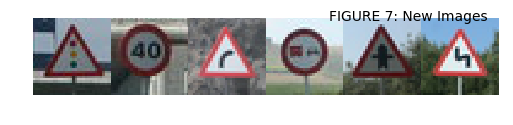

In [114]:
from scipy import misc 
import os

# Load all the images 
new_images = [os.path.join(r, fn) for r,d,f in os.walk('./new_images') for fn in f]
new_images = np.asarray([np.asarray(misc.imread(img_path)) for img_path in new_images])
new_images_clahe = np.asarray([clahe_RGB(new_img, clipLimit=1.0, tileGridSize=(4,4)) for new_img in new_images])


figure_7 = plt.figure(figsize=(10,1))
for i in range(0, len(new_images)):
    figure_7_ax = figure_7.add_subplot(np.ceil(len(new_images)/figure_1_row_length), figure_1_row_length, i+1)
    figure_7_ax.imshow(new_images[i], aspect='auto', interpolation='nearest')
    figure_7_ax.axis('off')
    
figure_7.subplots_adjust(wspace=0, hspace=0)
figure_7.suptitle('FIGURE 7: New Images')

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

**Answer:** 
#### Performance on the additional images 
The classifier is applied below, and the softmax probabilites are reported. As stated above *the set of images I have chosen contains one traffic sign class which is **not** present in the provided training and testing data*. This is deliberate and for the sake of experiment, as discussed further below. 

Excluding the 'Max 40 km/h' sign, not present in the original training set, the model classified 4/5 images correctly, corresponding to *80% accuracy*. It is fair to say that the model performs well, given the difference between the Spanish roadsign for 'No passing for vehicles over 3500kg' (fourth from the left, above), and its German counterpart. 
 
The 'Max 40km/h,' which, again, is not present in the original dataset, is classified as a 'Max 60km/h' sign.

This problem highlights an interesting question: Is it best to have a single model, which is able to classify an image as having 'the general aspect of a Max 40 km\h' sign? Or is it best to have separate models for each possible set of international road signage? The first option would certainly improve adaptability, and, perhaps, be more robust in the face of the unexpected, but it would certainly require significantly more training data, time and infrastructure.

#### Model performance on the provided testing dataset 
The model, with pre-processed images is 96.6% accuracy in the testing dataset. Without CLAHE pre-processing, the model tsting accuracy is 88%. As described previously, since this operation is independent for each input image, it is appropriate for any input to the model, be it training or testing. 
Considering the small sample size of the additional n=5 sample set shown in Figure 7 (for obvious reasons we exclude the Max 40km/h sign for this discussion), the accuracy of the model on these images is reasonable, especially considering that they are from a different nation. With a larger dataset of Spanish traffic signs, it would be wise to expect a lower accuracy than 80%, and a greater discrepancy between the testing accuracy on the GTSB-based test set, and the accuarcy on the small testing set in Figure 7.  The signs selected here, a part from one, are conincidentally quite similar to German traffic sign. A larger set would contain more of the Spanish signs which differ somewhat more from their German counterparts. For the sake of record-keeping, wikimedia has images of Spanish signs here: https://commons.wikimedia.org/wiki/Road_signs_of_Spain and images of German signs here: https://en.wikipedia.org/wiki/Road_signs_in_Germany . 

In [112]:
with model_data['graph'].as_default():
    with tf.Session() as sess: 
        saver = model_data['saver']
        saver.restore(sess, './signception.chkpt')
        
        probs = sess.run(tf.nn.top_k(model_data['softmax_operation'], k=5), feed_dict={model_data['x']:new_images})
        
        print("New images - prediction without CLAHE:", probs)

New images - prediction without CLAHE: TopKV2(values=array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.16679099e-18,   4.00413061e-20,
          1.12109729e-29,   3.04075019e-34],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   2.91441259e-29,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   6.62831942e-12,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[26,  0,  1,  2,  3],
       [ 3,  5,  2,  7, 15],
       [20,  0,  1,  2,  3],
       [ 9, 15,  0,  1,  2],
       [11, 30,  0,  1,  2],
       [21,  0,  1,  2,  3]], dtype=int32))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:** As is unsurprising, for the inevitably mis-classified 'Max 40km\h' sign, the top 4 signs are all round, red-stroked  obligatory speed-limit signs. 

Interestingly, 'No passing for vehicles over 3.5 metric tons' does not appear in the top 5 most likely signs for its Spanish equivalent. This is an interesting outcome, partly due to the high degree of certainty (note that the probability is nearly 1) with which it is classified as a 'No passing' sign. As described above, there is a clear difference between then German and Spanish 'No passing for vehicles over 3.5 metric tons' signs. The rather 'absolutist' probabilites here suggest that applying some extra regularization to the model would be wise. For the purposes of this experiment, the above outcome will suffice. 

## Bibliography 

**Note:** A number of the articles mentioned below are not open access. Until my official graduation from my M.Sc., I have institutional access. 

**[1]** Cireşan, D., U. Meier, J. Masci, and J. Schmidhuber. 2011. “A Committee of Neural Networks for Traffic Sign Classification.” In The 2011 International Joint Conference on Neural Networks, 1918–21.

**[2]** Sermanet, Pierre, and Yann LeCun. 2011. “Traffic Sign Recognition with Multi-Scale Convolutional Networks.” In Neural Networks (IJCNN), The 2011 International Joint Conference on, 2809–13.

**[3]** Ruta, Andrzej, Yongmin Li, and Xiaohui Liu. 2010/1. “Real-Time Traffic Sign Recognition from Video by Class-Specific Discriminative Features.” Pattern Recognition 43 (1): 416–30.

**[4]** Stallkamp, J., M. Schlipsing, J. Salmen, and C. Igel. 2012. “2012 Special Issue: Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition.” Neural Networks: The Official Journal of the International Neural Network Society 32 (August). Oxford, UK, UK: Elsevier Science Ltd.: 323–32.

**[5]** Escalera, A. de la, J. M. Armingol, and M. Mata. 2003. “Traffic Sign Recognition and Analysis for Intelligent Vehicles.” Image and Vision Computing 21 (3): 247–58.

**[6]** Maldonado-Bascon, S., S. Lafuente-Arroyo, P. Gil-Jimenez, H. Gomez-Moreno, and F. Lopez-Ferreras. 2007. “Road-Sign Detection and Recognition Based on Support Vector Machines.” IEEE Transactions on Intelligent Transportation Systems 8 (2): 264–78.

**[7]** Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. 2016. Deep Learning. MIT Press.

**[8]** Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. 2012. “ImageNet Classification with Deep Convolutional Neural Networks.” In Advances in Neural Information Processing Systems 25, edited by F. Pereira, C. J. C. Burges, L. Bottou, and K. Q. Weinberger, 1097–1105. Curran Associates, Inc.

**[9]** Szegedy, C., W. Liu, Y. Jia, and P. Sermanet. 2015. “Going Deeper with Convolutions.” Proceedings of the. cv-foundation.org. http://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Szegedy_Going_Deeper_With_2015_CVPR_paper.html.

**[10]** Kingma, Diederik, and Jimmy Ba. 2014. “Adam: A Method for Stochastic Optimization.” arXiv [cs.LG]. arXiv. http://arxiv.org/abs/1412.6980.